# CoinGame solver using multi-agent advantage actor-critic (MAA2C) with a shared classical policy and joint classical critic.

In [9]:
import sys
sys.path.append('../') # Use parent dir.

In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import eqmarl
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from pathlib import Path
import json
from datetime import datetime
import numpy as np

In [12]:
output_dir = Path('./output/')
root_dir = output_dir/'coingame_maa2c_classical_pomdp'
root_dir.expanduser().mkdir(parents=True, exist_ok=True)

checkpoint_dir = root_dir / 'checkpoints'

metrics_file = root_dir / 'metrics-{datetime}.json'
model_actor_checkpoint_file = checkpoint_dir / 'actor' / 'cp-{datetime}.ckpt'
model_critic_checkpoint_file = checkpoint_dir / 'critic' / 'cp-{datetime}.ckpt'

In [13]:
n_actions = 4
n_agents = 2
observation_dim = 36
keepdims = [0,2,3] # Preserves observations indices [0,2,3], removes index [1] which contains info about other agent locations -- makes observation partially-observable.

In [15]:
# Shared actor.
model_actor = eqmarl.models.generate_model_CoinGame2_actor_classical_shared_pomdp(
    keepdims=keepdims,
    n_actions=n_actions,
    units=[12],
    name=f"actor-classical-shared"
    )
optimizer_actor = keras.optimizers.Adam(learning_rate=1e-3)

model_actor.build((None, observation_dim))
model_actor.summary()

Model: "actor-classical-shared"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 4, 3, 3)           0         
                                                                 
 lambda_2 (Lambda)           (None, 3, 3, 3)           0         
                                                                 
 flatten_2 (Flatten)         (None, 27)                0         
                                                                 
 dense_1 (Dense)             (None, 12)                336       
                                                                 
 policy (Dense)              (None, 4)                 52        
                                                                 
Total params: 388
Trainable params: 388
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Joint critic.
model_critic = eqmarl.models.generate_model_CoinGame2_critic_classical_joint_pomdp(
    keepdims=keepdims,
    n_agents=n_agents,
    units=[12],
    name=f"critic-classical-joint"
    )
optimizer_critic = keras.optimizers.Adam(learning_rate=1e-3)

model_critic.build((None, n_agents, observation_dim))
model_critic.summary()

Model: "critic-classical-joint"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_4 (Reshape)         (None, 2, 4, 3, 3)        0         
                                                                 
 lambda_3 (Lambda)           (None, 2, 3, 3, 3)        0         
                                                                 
 reshape_5 (Reshape)         (None, 2, 27)             0         
                                                                 
 locally_connected1d_1 (Loca  (None, 2, 12)            672       
 llyConnected1D)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 24)                0         
                                                                 
 v (Dense)                   (None, 1)                 25        
                                            

## Training

In [17]:
gamma = 0.99
alpha = 0.001
params = {
    'domain_name': 'CoinGame-2',
    'gamma': gamma,
    'time_limit': 50,
}
env = eqmarl.environments.coin_game.vector_coin_game_make(params)

def episode_metrics_callback(env: eqmarl.environments.coin_game.CoinGameEnvironment):
    
    coins_collected = env.domain_values()[env.get_index('coins_collected')]
    own_coins_collected = env.domain_values()[env.get_index('own_coins_collected')]
    undiscounted_reward = np.sum(env.undiscounted_returns)
    discounted_reward = np.sum(env.discounted_returns)
    own_coin_rate = own_coins_collected/coins_collected if coins_collected != 0 else 0
    
    return dict(
        coins_collected=coins_collected,
        own_coins_collected=own_coins_collected,
        own_coin_rate=own_coin_rate,
        undiscounted_reward=undiscounted_reward,
        discounted_reward=discounted_reward,
    )

algo = eqmarl.algorithms.MAA2C(
    env=env,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=gamma,
    alpha=alpha,
    episode_metrics_callback=episode_metrics_callback,
    )

In [18]:
# Time of training start.
datetime_start = datetime.now().isoformat()

# Set model checkpoint files to have timestamp of training start.
model_actor_checkpoint_file_current = str(model_actor_checkpoint_file).format(datetime=datetime_start)
model_critic_checkpoint_file_current = str(model_critic_checkpoint_file).format(datetime=datetime_start)
metrics_file_current = str(metrics_file).format(datetime=datetime_start)

# Train models using algorithm.
reward_history, metrics_history = algo.train(
    n_episodes=3000,
    callbacks=[
        eqmarl.AlgorithmResultCheckpoint(filepath=metrics_file_current, save_freq=100, verbose=True),
        ],
    )

# Save results to file.
algo.save_train_results(metrics_file_current, reward_history, metrics_history)

Training for 3000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/3000 [00:00<?, ?episode/s]

Episode 101:   3%|▎         | 101/3000 [00:19<08:59,  5.37episode/s, coins_collected=5, discounted_reward=-.998, episode_reward=[ 1. -2.], own_coin_rate=0.4, own_coins_collected=2, undiscounted_reward=-1]  

Saving results at episode 100 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 201:   7%|▋         | 201/3000 [00:38<08:36,  5.42episode/s, coins_collected=12, discounted_reward=-.598, episode_reward=[ 1. -1.], own_coin_rate=0.5, own_coins_collected=6, undiscounted_reward=0]   

Saving results at episode 200 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 300:  10%|█         | 300/3000 [00:57<08:41,  5.17episode/s, coins_collected=4, discounted_reward=2.83, episode_reward=[2. 2.], own_coin_rate=1, own_coins_collected=4, undiscounted_reward=4]         

Saving results at episode 300 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 401:  13%|█▎        | 401/3000 [01:17<08:00,  5.40episode/s, coins_collected=10, discounted_reward=0.517, episode_reward=[-1.  1.], own_coin_rate=0.5, own_coins_collected=5, undiscounted_reward=0]  

Saving results at episode 400 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 501:  17%|█▋        | 501/3000 [01:36<07:44,  5.38episode/s, coins_collected=8, discounted_reward=3.09, episode_reward=[3. 1.], own_coin_rate=0.75, own_coins_collected=6, undiscounted_reward=4]      

Saving results at episode 500 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 601:  20%|██        | 601/3000 [01:55<07:49,  5.11episode/s, coins_collected=4, discounted_reward=-.12, episode_reward=[ 3. -3.], own_coin_rate=0.5, own_coins_collected=2, undiscounted_reward=0]    

Saving results at episode 600 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 701:  23%|██▎       | 701/3000 [02:14<07:31,  5.09episode/s, coins_collected=6, discounted_reward=1.09, episode_reward=[0. 2.], own_coin_rate=0.667, own_coins_collected=4, undiscounted_reward=2]    

Saving results at episode 700 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 801:  27%|██▋       | 801/3000 [02:32<06:46,  5.41episode/s, coins_collected=13, discounted_reward=8.42, episode_reward=[8. 3.], own_coin_rate=0.923, own_coins_collected=12, undiscounted_reward=11]  

Saving results at episode 800 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 901:  30%|███       | 901/3000 [02:51<06:31,  5.36episode/s, coins_collected=15, discounted_reward=7.84, episode_reward=[7. 4.], own_coin_rate=0.867, own_coins_collected=13, undiscounted_reward=11]  

Saving results at episode 900 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1001:  33%|███▎      | 1001/3000 [03:10<06:13,  5.35episode/s, coins_collected=11, discounted_reward=7.38, episode_reward=[7. 2.], own_coin_rate=0.909, own_coins_collected=10, undiscounted_reward=9] 

Saving results at episode 1000 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1100:  37%|███▋      | 1100/3000 [03:29<06:31,  4.86episode/s, coins_collected=9, discounted_reward=5.41, episode_reward=[3. 4.], own_coin_rate=0.889, own_coins_collected=8, undiscounted_reward=7]     

Saving results at episode 1100 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1201:  40%|████      | 1201/3000 [03:49<05:52,  5.10episode/s, coins_collected=22, discounted_reward=15.3, episode_reward=[11.  9.], own_coin_rate=0.955, own_coins_collected=21, undiscounted_reward=20]

Saving results at episode 1200 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1301:  43%|████▎     | 1301/3000 [04:08<05:19,  5.32episode/s, coins_collected=25, discounted_reward=15.3, episode_reward=[14.  5.], own_coin_rate=0.88, own_coins_collected=22, undiscounted_reward=19] 

Saving results at episode 1300 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1400:  47%|████▋     | 1400/3000 [04:28<06:00,  4.44episode/s, coins_collected=21, discounted_reward=17.1, episode_reward=[11. 10.], own_coin_rate=1, own_coins_collected=21, undiscounted_reward=21]    

Saving results at episode 1400 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1501:  50%|█████     | 1501/3000 [04:47<04:49,  5.17episode/s, coins_collected=18, discounted_reward=14.3, episode_reward=[15.  3.], own_coin_rate=1, own_coins_collected=18, undiscounted_reward=18]    

Saving results at episode 1500 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1601:  53%|█████▎    | 1601/3000 [05:07<04:30,  5.18episode/s, coins_collected=22, discounted_reward=15.4, episode_reward=[15.  5.], own_coin_rate=0.955, own_coins_collected=21, undiscounted_reward=20]

Saving results at episode 1600 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1701:  57%|█████▋    | 1701/3000 [05:26<04:09,  5.20episode/s, coins_collected=22, discounted_reward=17.1, episode_reward=[10. 12.], own_coin_rate=1, own_coins_collected=22, undiscounted_reward=22]    

Saving results at episode 1700 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1801:  60%|██████    | 1801/3000 [05:45<03:43,  5.37episode/s, coins_collected=23, discounted_reward=17.8, episode_reward=[13. 10.], own_coin_rate=1, own_coins_collected=23, undiscounted_reward=23]    

Saving results at episode 1800 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 1901:  63%|██████▎   | 1901/3000 [06:04<03:48,  4.82episode/s, coins_collected=24, discounted_reward=15.8, episode_reward=[ 9. 11.], own_coin_rate=0.917, own_coins_collected=22, undiscounted_reward=20]

Saving results at episode 1900 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2001:  67%|██████▋   | 2001/3000 [06:22<03:05,  5.38episode/s, coins_collected=23, discounted_reward=16.3, episode_reward=[10. 11.], own_coin_rate=0.957, own_coins_collected=22, undiscounted_reward=21]

Saving results at episode 2000 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2101:  70%|███████   | 2101/3000 [06:41<02:55,  5.13episode/s, coins_collected=24, discounted_reward=17.3, episode_reward=[ 7. 15.], own_coin_rate=0.958, own_coins_collected=23, undiscounted_reward=22]

Saving results at episode 2100 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2201:  73%|███████▎  | 2201/3000 [07:00<02:36,  5.10episode/s, coins_collected=30, discounted_reward=21.7, episode_reward=[18. 10.], own_coin_rate=0.967, own_coins_collected=29, undiscounted_reward=28]

Saving results at episode 2200 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2301:  77%|███████▋  | 2301/3000 [07:19<02:14,  5.20episode/s, coins_collected=28, discounted_reward=21.7, episode_reward=[11. 17.], own_coin_rate=1, own_coins_collected=28, undiscounted_reward=28]    

Saving results at episode 2300 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2401:  80%|████████  | 2401/3000 [07:38<01:57,  5.09episode/s, coins_collected=19, discounted_reward=15, episode_reward=[11.  8.], own_coin_rate=1, own_coins_collected=19, undiscounted_reward=19]      

Saving results at episode 2400 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2501:  83%|████████▎ | 2501/3000 [07:58<01:33,  5.31episode/s, coins_collected=26, discounted_reward=18.8, episode_reward=[15.  9.], own_coin_rate=0.962, own_coins_collected=25, undiscounted_reward=24]

Saving results at episode 2500 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2600:  87%|████████▋ | 2600/3000 [08:16<01:17,  5.17episode/s, coins_collected=25, discounted_reward=19.6, episode_reward=[14. 11.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 2600 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2701:  90%|█████████ | 2701/3000 [08:35<00:56,  5.29episode/s, coins_collected=27, discounted_reward=16.7, episode_reward=[ 6. 15.], own_coin_rate=0.889, own_coins_collected=24, undiscounted_reward=21]

Saving results at episode 2700 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2800:  93%|█████████▎| 2800/3000 [08:54<00:45,  4.43episode/s, coins_collected=28, discounted_reward=20.4, episode_reward=[10. 16.], own_coin_rate=0.964, own_coins_collected=27, undiscounted_reward=26]

Saving results at episode 2800 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 2901:  97%|█████████▋| 2901/3000 [09:14<00:18,  5.23episode/s, coins_collected=25, discounted_reward=19.8, episode_reward=[ 8. 17.], own_coin_rate=1, own_coins_collected=25, undiscounted_reward=25]    

Saving results at episode 2900 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


Episode 3000: 100%|██████████| 3000/3000 [09:33<00:00,  5.23episode/s, coins_collected=26, discounted_reward=17.2, episode_reward=[ 9. 13.], own_coin_rate=0.923, own_coins_collected=24, undiscounted_reward=22]

Saving results at episode 3000 to file output/coingame_maa2c_classical_pomdp/metrics-2024-04-11T15:19:57.284377.json


In [19]:
# Load metrics from file.
reward_history, metrics_history = algo.load_train_results(metrics_file_current)

Text(0.5, 1.0, 'Score')

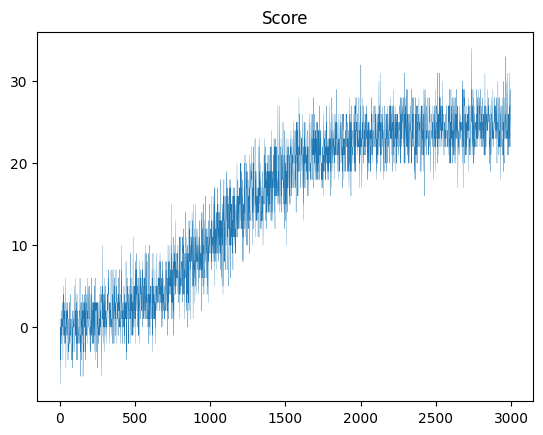

In [20]:
score = np.sum(reward_history, axis=-1)
plt.plot(score, linewidth=.2)
plt.title('Score')

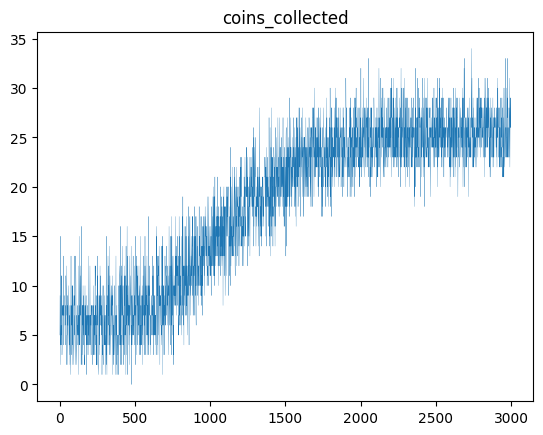

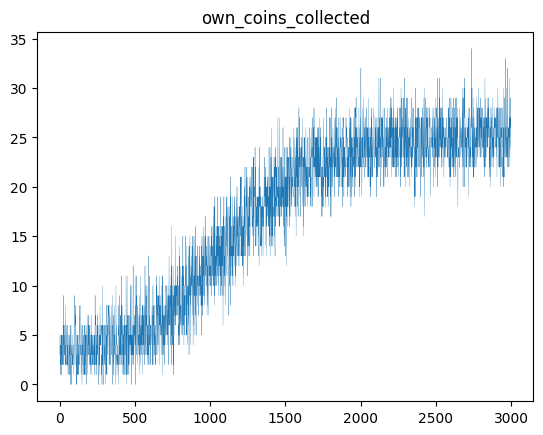

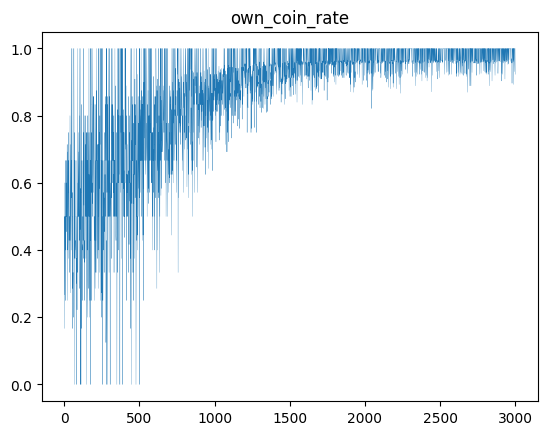

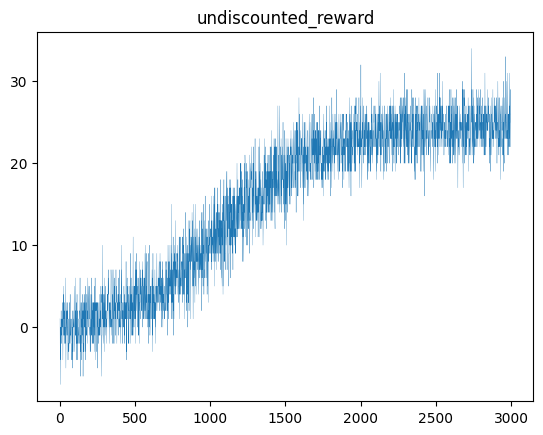

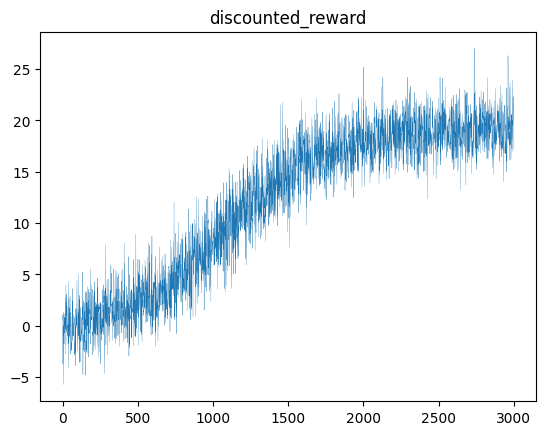

In [21]:
for k, v in metrics_history.items():
    plt.figure()
    plt.title(k)
    plt.plot(v, linewidth=.2)